

# 실습 8. 오토인코더를 통한 워드 임베딩 학습

본 실습에서 사용하는 데이터셋의 출처는 다음과 같음을 밝힌다.

1) https://code.google.com/archive/p/word2vec/source/default/source

2) https://www.evanjones.ca/software/wikipedia2text.html

### 0. 인트로

In [3]:
import numpy as np
import torch
from gensim.models.keyedvectors import KeyedVectors
import codecs
from nltk.tokenize import word_tokenize


이번 실습에서는 지난 시간에 배웠던 오토인코더와 워드 임베딩이란 두 중요 개념을 확인하는 시간을 가질 것이다. 먼저 새로운 개념인 ’context matrix’란 문맥 행렬을 배우고 이를 생성하는 코드를 작성해볼 것이다. 문맥 행렬은 한 번에 생성되는 것도 아니고, 내장 함수가 존재하는 것도 아니라서 우리가 직접 만들어야 한다. 그러기 위해서는 주어진 단어나 토큰에 코드를 부여하고, 특정 기준으로 정렬하는 작업을 거쳐야 한다. 이렇게 생성한 문맥 행렬은 그럼 어디에 쓰이는 걸까? 바로 오토인코더의 학습 과정 전반에 이용된다. 앞에서 수많은 신경망 학습에서 ‘batch’란 개념을 배웠다. 학습 효율을 높이기 위해 데이터를 여러 batch로 나누어 학습했는데, 문맥 행렬을 여러 batch로 쪼개어서 오토인코더의 학습을 진행할 것이다. 이렇게 학습한 오토인코더에서 우리는 데이터가 워드 임베딩 된 것을 새로 얻을 수 있다. 이 임베딩이 이제 어떻게 이루어져 있는지까지 확인하는 것이 이번 실습에서 우리가 할 일이다.

### 1. 문맥 행렬의 이해

단어들을 수적 표현, 즉 코드로 표현해야 문맥 행렬을 형성할 수 있다. 문맥 행렬이 어떤 형태를 띠는지는 나중에 더 자세히 보기로 하고, 지금 우리가 할 것은 단어나 토큰에 코드를 부여하는 것이다. 무작위로 코드를 부여할 순 없고 어떤 기준을 갖고 코드를 생성할 것인데 여기에서 중요하게 작용하는 요소가 바로 ‘context’, 문맥이다. 어떤 단어가 등장했을 때 주변에 등장하는 여러 단어를 고려하여 문장의 해석을 해내는 것이 문맥을 파악하는 일이다. 예를 들어 "dogs are loud pets"와 "cats are quiet pets"의 예문에서 ‘dogs’와 ‘cats’이 가진 특징을 비교하는 것도 중요하지만, 이 예문에서 공통으로 등장하는 ‘pet’의 알맞은 의미를 전달하는 것도 필요하다. ‘pet’이란 단어와 자주 등장했던 단어들을 찾다 보면 "cat", "dog“, "owner", "care" 등의 단어들이 모두 ‘pet’과 자주 등장한 단어임을 알 수 있게 되고, 이를 ‘pet’이 갖는 코드에 반영할 수 있는 알맞은 수적인 표현을 생각해내야 한다.


이 과정을 시행하기 위해 우리는 문맥이란 개념을 인공지능에서 새롭게 정의하고, 문장을 스캔하여 그 문맥을 파악할 때 사용할 문맥 창(context window)의 크기를 설정해야 한다. 이렇게 설정한 문맥 창 내에서 어떤 단어와 다른 단어들이 함께 나타나는 정도를 계산하여 반영한 ‘context matrix’, 즉 문맥 행렬이란 새로운 개념을 도입한다.


문맥 행렬의 각행들은 문맥 창에서 그 중심에 오는 ‘중심어(center word)’에 대한 정보를 담고 있다. 만약 “I am into watching movies.”란 문장이 있다면 이 문맥 창에서 중심어는 “into”, 문맥어(context word)는 중심어 기준 양쪽으로 2개씩 있다.(이때 문맥 창의 크기는 2라고 생각하면 된다. 중심어를 기준으로 양쪽에 몇 개의 단어가 오는지가 창 크기의 개념이다.)


4개의 문맥어가 단어 “into”와 함께 등장한 횟수는 문맥 행렬을 이루는 각 열에 추가된다. 만약 “into”란 중심어가 문맥 행렬에서 1행에 존재한다면 1행에서 각 문맥어에 해당하는 열에 문맥어가 등장한 횟수를 기록하면 된다. 다시 말하면, 주어진 문맥 창의 중심에 i라는 단어가 등장하고, 문맥어로 j가 i와 함께 등장하는 횟수를 라고 할 수 있다. 이것이 바로 문맥 행렬의 개념이다. 아래의 문맥 행렬은 앞서 '워드 임베딩에서 배운, 의미론적 유사성을 기반으로 워드 임베딩을 행했을 때 나온 예시이므로 다시 한번 이해하고 넘어가자.

|          | cute | little | scary |
|----------|----------|----------|----------|
| dragon   | 0   | 1   | 8   |
| cat   | 28   | 42   | 4   |
| puppy   | 30  | 39  | 0  |


문맥 행렬을 만들 때 또 한가지 고려해야 할 점은 행렬의 크기이다. 한 글에 포함된 단어 수가 너무 많아지면 중심어와 문맥어 수도 같이 많아지는데 이 경우 모든 단어를 반영하다 보면 행렬의 크기가 무한히 커지는 불편함이 있다. 이를 어느 정도 해결하기 위해 중심어와 문맥어 수를 제한한 ‘max_vocab_words’와 ‘max_context_words’ 개념을 도입한다. 가장 빈번하게 등장한 ‘max_vocab_words’을 기준으로 중심어 수를 제한하고 ‘max_context_words’로 우리가 고려하는 문맥어 수도 제한한다. 문맥 행렬을 이루는 행과 열은 각각 중심어와 문맥어이므로 문맥 행렬에서 행의 개수는 ‘max_vocab_words’, 열의 개수는 ‘max_context_words’을 따라가 그 shape이 (max_vocab_words, max_context_words)임을 추측할 수 있다.

### 2. 문맥 행렬 만들기

#### 1) 문맥 행렬 형성을 위한 사전 작업
기본적인 개념들을 숙지했으니 이제 문맥 행렬을 만들기 위한 과정을 거칠 것이다. 리마인드하자면, 문맥 행렬을 만드는 이유는 오토인코더의 학습을 위해서다. 먼저 주어진 문장을 여러 단어로 나누는 작업, 즉 데이터를 토큰화하기 위해서 ‘nltk(natural language toolkit tutorial)’을 사용한다. 토큰화 한 단어들을 문맥 행렬에 반영하기 위해선 각 토큰에 숫자 코드를 부여하는 작업이 요구된다. 그냥 단어를 넣으면 컴퓨터가 처리할 수 없으므로 컴퓨터가 이해할 수 있는 코드로 행렬을 구성할 것이다. 이 작업을 위해 ‘generate_sorted_words‘, ‘generate_word2code‘, ‘convert_tokens_to_codes‘의 3가지 함수를 만들어야 한다.

첫 번째로 ’generate_sorted_words‘은 각 문장을 이루는 토큰을 정렬하는데 사용되며 그 기준은 단어가 등장한 횟수이다. 그 횟수를 기준으로 내림차순으로 정렬하기 때문에 이 함수를 통해 가장 자주 등장한 ’max_vocab_words‘을 결정하는 단어를 찾는 작업이 쉬워질 것이다. 방금 ‘generate_sorted_words‘에서 생성한 정렬된 리스트를 ’generate_word2code‘ 함수에 넘겨주면 이 함수는 내림차순으로 정렬된 각 단어에 정수 코드를 부여한다. 따라서 가장 많이 등장한 단어는 코드 0을 가져가고 그 다음은 1, 2의 식으로 더 높은 인덱스를 가질 것이다. 만약 ’max_vocab_words’ = 8이었다면 ‘generate_word2code’에서 부여받은 코드가 8인 단어까지만 문맥 행렬에 반영한다. 마지막으로 ’convert_tokens_to_codes‘에서는 무작위로 정렬된 리스트를 입력으로 받으면 우리가 ‘generate_word2code‘에서 부여한 단어별 코드를 이용해 이 리스트를 코드 형태로 된 리스트로 다시 내보낸다. 이를 충분히 숙지하고 아래 코드를 작성해보자. 혹시 잘 모르겠다면 코드에 달린 주석을 유심히 보길 바란다.


In [4]:
def generate_sorted_words(tokens):
    """ 특정 단어들로 이루어진 리스트를 생성하고 이들을 등장한 빈도수를 기준으로 내림차순으로 정렬

    매개변수(Parameters)
    ----------
    tokens: List[str]
        여러 토큰으로 이루어진 리스트. (혹은 단어들), e.g., ["the", "cat", "in", "the", "in", "the"]

    반환 값(Returns)
    -------
    List[str]
        등장한 순서를 기준으로 내림차순으로 정렬한 토큰으로 이루어진 리스트, e.g., ["the", "in", cat"]
    """
    # 여기에 코드 작성
    from collections import Counter
    counter = Counter(tokens)
    words = [word for word, count in counter.most_common()]
    return words

In [5]:
def generate_word2code(sorted_words):
    """ 등장한 횟수 순으로 정렬된 단어 리스트에서 각 단어의 위치로 단어를 매핑하는 사전을 생성하는 함수

    매개변수(Parameters)
    ---------
    sorted_words: List[str]
        등장 횟수 순으로 정렬된 단어 리스트, e.g., ["bat", "apple", "cat"]

    반환 값(Returns)
    -------
    Dict[str, int]
        단어를 정수 코드로 매핑하는 사전 e.g., {"bat": 0, "apple": 1, "cat": 2}
    """
    # 여기에 코드 작성
    return {word: index for index, word in enumerate(sorted_words)}

In [6]:
def convert_tokens_to_codes(tokens, word2code):
    """ 토큰을 코드로 전환하는 함수

    매개변수(Parameters)
    ---------
    tokens: List[str]
        N개의 단어로 이루어진 리스트, e.g., ["bat", "cat", "apple"]

    word2code: Dict[str ,int]
        정수 코드로 각 단어를 매핑하는 사전, e.g., {"apple": 0, "bat": 1, "cat": 2}

    반환 값(Returns)
    -------
    np.ndarray, shape-(N, )
        입력된 단어들에 해당하는 정수 코드로 이루어진 배열, e.g., [1, 2, 0].
    """
    # 여기에 코드 작성
    return np.array([word2code[token] for token in tokens])

위 코드가 와닿지 않는다면 다음 예시로 다시 이해해보자. 가령 example = [“the“, “cat“, “in“, “the“, “in“, “the“]의 리스트가 주어졌다고 해보자. 먼저 위 함수를 활용해 ‘example’에 등장한 토큰을 등장한 횟수대로 정렬해보고, 코드를 부여해보자. ‘generate_sorted_words’를 이용한다면, 가장 많이 등장한 단어는 ”the“이고 가장 적게 등장한 단어는 ”cat“이므로 example은 [”the“, ”in“, ”cat“]으로 정리될 것이다. 이 리스트를 ‘generate_word2code’에 넣으면 {”the“: 0, ”in“: 1, ”cat“: 2}와 같은 형태로 코드가 부여된다. 마지막으로 ‘convert_tokens_to_codes’에 이 example을 넣게 되면 우리는 [0, 2, 1, 0, 1, 0]의 리스트를 얻을 것이라 예상할 수 있다. 토큰 ["a", "a", "b", "c", "c", "c", "c", "a", "b", "c"]을 이용해서 각 함수가 어떤 결과를 도출할지 예상해보고 예상과 일치하는지 비교해보라.

In [7]:
tokens =["a","a","b","c","c","c","c","a","b","c"]
# 여기에 코드 작성
sorted_words = generate_sorted_words(tokens) # 많이 나온 순서대로 정렬
print(sorted_words)

word2code = generate_word2code(sorted_words)
print(word2code)

codes = convert_tokens_to_codes(tokens, word2code)
print(codes)

['c', 'a', 'b']
{'c': 0, 'a': 1, 'b': 2}
[1 1 2 0 0 0 0 1 2 0]


#### 2) 문맥 행렬 형성을 위한 코드 작성
이제 문맥 행렬을 생성하고 오토인코더를 학습시키는 과정이 남았다. 문맥 행렬을 생성하는데 쓰일 함수는 ‘generate_word_by_context’이다. 물론 내장된 함수가 아니고 우리가 직접 써내려가야한다. 먼저 shape이 (max_vocab_words, max_context_words)인 영행렬(모든 요소가 0인 행렬)을 만들고 거기에 중심어와 문맥어의 관계를 추가한다고 생각하면 쉽다. 일단 주어진 문장을 앞에서부터 순서대로 함수가 스캔할 것인데, 스캔을 하는 시작점은 맨 앞에 오는 단어가 아니라 첫 번째 중심어가 등장하는 곳이다. 중심어를 기준으로 문맥 창 안에서 문맥어는 어떤 것이 등장하는지 확인할 것이다. 따라서 문맥 창의 크기가 달라지면 문맥어 수도 달라질 것이다. 이를 지정하는 변수가 바로 ‘context_size’이고 이를 함수에서 정의한 다음 사용할 것이다. 문맥 창 크기가 결정하는 것은 문맥어 수뿐 아니라 첫 번째 중심어도 있다. 만약 context_size = 2라면 첫 번째 중심어는 문장의 맨 처음에서부터 3번째 단어에 해당한다.

![image1](https://drive.google.com/uc?id=1TEM7vUrmptc-MODtPduMo6F-SDMLDXS0)

이렇게 문장을 스캔하다가 만약 중심어가 부여받은 코드가 ‘max_vocab_words’보다 커진다면 함수는 그 중심어를 건너뛰고 ‘max_vocab_words’보다 코드가 작거나 같은 중심어에 대해서만 분석을 진행할 것이다. 물론 ‘max_context_words’보다 큰 코드를 갖는 문맥어에 대해서도 문맥 행렬을 구성할 때에는 배제해야 한다. 따라서 이 두 가지 조건을 만족하는 문맥어와 중심어를 가지고 문맥 행렬을 내놓을 것이다. 제대로 된 ‘generate_by_context’ 함수를 소개하기 이전에 이 함수를 간략하게 설명한 다음의 의사(pseudo) 코드를 이해해보면 좋을 것 같다.


2차원 배열을 모두 0으로 초기화하며 이때의 shape은 (max_vocab_words, max_context_words)에 해당한다.

첫 번째 중심어를 시작으로 시퀀스를 따라 창을 옆으로 이동시키고 그 문맥창 내에서 단어끼리 동시에 등장한 횟수를 세어 나갈 것이다.

# pesudo-code


아래 코드는 pesudo-code이다.
```python
if code of center word is >= max_vocab_words:
    skip  # 중심어의 코드가 임의로 설정한 max_vocab_words 보다 큰 경우 문맥 행렬에 반영하지 않는다.

for each word in context (on left and right sides)
    if code of context word < max_context_words # 문맥어의 코드가 max_context_words 보다 작은 경우 문맥 행렬에 반영한다.
        add 1.0 to matrix element in row-(center word) and column-(context word)
            or (if weighting by distance)
        add 1.0 / (distance from center to context)
        # 중심어와 문맥어 간 거리를 고려할 경우 그 거리로 나눠주는데,
        # 이 부분은 바로 다음 함수‘generate_word_by_context’의 weight_by_distance와 관련된 부분이다.
```




 위 for-loop 문을 기반으로 문맥 행렬에 반영될 중심어와 문맥어를 선택하고 행렬을 만들어나갈 것이다. 행렬을 생성한 후 주어진 테스트 케이스를 함수에 통과시켜 함수가 제대로 구동하는지 확인하는 것까지 해볼 것이다. 사실 문맥 행렬이 도대체 어떤 형태를 띠는지 감을 잡지 못했을 수도 있다. 일단 코드를 전체적으로 이해해보고 테스트 케이스를 이 함수에 통과시켜 얻은 행렬을 보면서 문맥 행렬이 생성되는 과정을 이해해봐도 좋을 것 같다. ‘generate_by_context’ 함수는 numba 라이브러리의 njit라는 데코레이터를 도입하여 함수의 최적화된 버전을 컴파일할 것이다. 먼저 라이브러리 numba에서 njit를 ‘from numba import njit’로 불러오고 함수가 시작되는 코드 바로 위에 ‘@njit’를 추가해주면 된다. 이 @njit가 함수의 성능 구현을 보다 빠르게 해줄 수 있는 이유는 LLVM(low-level virtual machine) 환경에서 함수를 실행하기 때문이다. Numba 라이브러리는 파이썬과 NumPy 코드 일부를 LLVM에 최적화된 명령어로 컴파일할 수 있도록 설계되었기에 우리는 빠르게 함수를 실행시킬 수 있다. 이를 통해 for-loop으로 이루어진 함수이지만 이 데코레이터로 그 속도를 어느 정도 높여줄 것이다. 다만 파이썬에 해당하는 코드의 일부만 지원하기 때문에 한계가 있다. 이 점들을 잘 기억하고 다음의 함수 generate_word_by_context의 코드를 이해해보자. 주석에 앞에서 소개했던 ‘max_vocab_words’와 같은 매개변수 설명들도 들어있으니 확실히 이해해보길 바란다.

In [8]:
!pip install numba

In [9]:
from numba import njit

@njit
def generate_word_by_context(
    codes,
    max_vocab_words = 1000,
    max_context_words = 1000,
    context_size = 2,
    weight_by_distance = True,
):
    """ 문맥어와 함께 등장한 횟수가 반영된 중심어에 대한 배열을 생성한다.

    매개변수(Parameters)
    ----------
    codes: numpy.ndarray, shape-(N, )
        단어 코드로 이루어진 시퀀스 (정수).

    max_vocab_words: int
        어휘에 포함시킬 단어의 최대 개수 (행렬의 행에 해당).
        이는 문맥창 내에서 중심어가 가질 수 있는 정수 코드의 최댓값을 의미한다.

    max_context_words: int
        가능한 문맥어로 고려될 수 있는 단어의 최대 개수(행렬에서 열에 해당).
        문맥을 스캔할 때 고려하는 단어 코드의 최댓값을 의미한다.

    context_size: int
        문맥창에서 중심어를 기준으로 양쪽(중심어의 왼쪽과 오른쪽)으로 고려할 단어의 개수

    weight_by_distance: bool
        문맥어와 중심어간 거리를 반영하여 가중치를 매길지 여부(거리로 나누어줌으로써 단어끼리 멀리 떨어져 있을수록 낮게 가중치가 매겨진다.)

            False --> 기여도는 is 1.0
            True  --> 기여도는 is 1.0 / (중심어 위치와 문맥어간 거리)

        예를 들어, ["i", "am", "scared", "of", "dogs"]이 [45, 10, 222, 25, 88]의 단어 코드를 갖는다고 가정해보자.

        weight_by_distance가 ‘False’일 경우,
            X[222, 45], X[222, 10], X[222, 25], and X[222, 88] 성분은 모두 1씩 증가한다.

        weight_by_distance가 ‘True’일 경우,
            X[222, 45] += 1.0/2  <-- "i" 와 "scared" 간 거리가 2이므로
            X[222, 10] += 1.0/1  <-- "am" 과 "scared" 간 거리가 1이므로
            X[222, 25] += 1.0/1  <-- "of" 와 "scared" 간 거리가 1이므로
            X[222, 88] += 1.0/2  <-- "dogs" 와 "scared" 간 거리가 2이므로

    반환 값(Returns)
    -------
    ndarray, shape=(max_vocab_words, max_context_words)
        행은 단어 수 ,열은 문맥어 수, 그리고 행렬을 이루는 성분은 어떤 중심어와 문맥어가 동시에 일어난 횟수를 센 값인 행렬이 반환값
    """
    # 먼저 0으로 이루어진 2차원 배열로 행렬을 초기화하기 (용량 감소 차원에서 ‘dtype=np.float32’로 설정하도록 하자.)
    # 여기에 코드 작성
    X = np.zeros((max_vocab_words, max_context_words), dtype = np.float32)

    # 시퀀스를 따라 창을 움직이면서 중심어와 문맥어 코드가 동시에 등장하는 횟수를 센다.
    # Hint: 메인 루프에서 사용하는 인덱스는 문맥창의 중심을 가리키도록 설정하자.
    # 중심어에 대하여 반복되는 코드
    # 여기에 코드 작성
    for word_pos in range(context_size, len(codes) - context_size):
        center_code = codes[word_pos]

        if center_code >= max_vocab_words:
            continue

       # 문맥창 내에서 반복되는 코드
       # SOLTUION
        for j in range(-context_size, context_size + 1):
            if j == 0:
                continue
            context_code = codes[word_pos + j]
            if context_code < max_context_words:
                value = 1.0
                if weight_by_distance:
                    value = 1.0 / abs(j)
                X[center_code, context_code] += value
    return X

In [10]:
# 시퀀스가 이미 단어 코드가 할당된 상태일 때
sequence = np.array([2, 3, 4, 9, 6, 7])
context_matrix = generate_word_by_context(
    sequence,
    max_vocab_words = 8,
    max_context_words = 8,
    context_size = 2,
    weight_by_distance = True, #거리 고려
)
print(context_matrix)

[[0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 1.  0.  0.  0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]]



#### 3) 문맥 행렬 생성해보기

테스트 케이스로 [2, 3, 4, 9, 6, 7]이란 시퀀스를 ‘codes’에 넣어보면 출력으로 나온 문맥 행렬은 다음과 같이 나와야 한다. (참고로 sequence에 해당하는 리스트 [2, 3, 4, 9, 6, 7]은 이미 ‘convert_tokens_to_code’ 함수를 거쳐서 코드가 부여된 상태이다. 즉 코드 2에 해당하는 맨 처음에 오는 단어가 가장 많이 등장하고, 코드 9에 해당하는 단어는 가장 적게 등장했을 것이다.) 이 테스트 케이스로 아래 문맥 행렬로 확실하게 이 개념을 짚고 넘어가면 좋을 듯하다.

<center>[[0.  0.  0.  0.  0.  0.  0.  0.]</center>  

<center>[0.  0.  0.  0.  0.  0.  0.  0.]</center>

<center>[0.  0.  0.  0.  0.  0.  0.  0.]</center>

<center>[0.  0.  0.  0.  0.  0.  0.  0.]</center>

<center>[0.  0.  1.  1.  0.  0.  1.  0.]</center>

<center>[0.  0.  0.  0.  0.  0.  0.  0.]</center>

<center>[0.  0.  0.  0.  0.  0.  0.  0.]</center>

<center>[0.  0.  0.  0.  0.  0.  0.  0.]]</center>

먼저 ‘weight_by_distance’ 기능은 ‘False’로 꺼져있기 때문에 문맥 행렬에 숫자를 입력할 때 중심어와 문맥어 간 거리는 고려하지 않아도 된다. [2, 3, 4, 9, 6, 7]에서 context_size = 2이므로 중심어의 양쪽으로 문맥어가 2개씩 존재하고 문맥 창의 크기는 5가 된다. 따라서 문장을 함수가 스캔할 때 [2, 3, 4, 9, 6]과 [3, 4, 9, 6, 7]의 두 창을 이용한다. 그다음으로 ‘max_vocab_words = 8’이므로 중심어의 코드가 9인 두 번째 창 [3, 4, 9, 6, 7]은 문맥 행렬에 반영하지 않는다. 따라서 창 [2, 3, 4, 9, 6]만이 문맥 행렬에 반영되었을 것이고, 여기에서도 문맥어가 가질 수 있는 최대 코드, ‘maxt_context_words = 8’을 고려하면 9는 문맥어로 고려하지 않아야 한다. 중심어 코드가 4인 상황에서 문맥어가 갖는 코드는 2, 3, 6의 세 개다. 문맥어가 2인 경우 5행 3열에, 3인 경우 5행 4열에, 6인 경우 5행 7열에 1이 더해질 것이다. 만약 ’weight_by_distance =True‘으로 설정한다면 중심어와 문맥어간 거리로 더해진 1을 나눠주어야 한다. 다음 행렬이 ’weight_by_distance = True’일 때의 행렬이다.

![image](https://drive.google.com/uc?id=11SbLUDawVyT5JfrMjOrFvHkdD7j0eS8g)
 ### 3. 오토인코더 학습시키기

이제 모델 학습을 위한 모든 과정을 마쳤으니 우리가 쓸 데이터(앞선 n-gram 실습에서 사용했던 위키피디아 txt 파일)를 불러오고 오토인코더 모델을 본격적으로 학습시켜보자. 아래 코드에 따라 데이터를 불러오는데, 경로 설정은 반드시 텍스트 파일이 저장된 위치로 설정해주어야 한다.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
with open('/content/drive/MyDrive/OUTTA/week8/tokens.txt', 'r', encoding = 'UTF-8') as f:
    token = f.read()

tokens_list = token.split()
print(f"{len(tokens_list)} tokens(s)")

11613998 tokens(s)


앞서 문맥 행렬을 생성하는 ‘generate_by_context’ 함수를 만들기 전에 데이터를 여러 토큰으로 나누고 코드를 부여하기 위해 만들었던 함수로 토큰을 코드로 바꿔주는 코드를 아래에 작성해보자.


In [11]:
# 여기에 코드 작성
sorted_words = generate_sorted_words(tokens_list)
word2code = generate_word2code(sorted_words)
codes = convert_tokens_to_codes(tokens_list, word2code)

이제 임의로 ’max_vocab_words’와 ‘max_context_words’을 설정하고 context_size를 지정하여 함수가 문장을 스캔하여 문맥 행렬을 만들 수 있도록 ‘generate_by_context’ 함수를 사용해보자.

(위키피디아 txt 파일 특성상 max_vocab_words = 10_000, max_context_words = 1000, context_size = 4, weight_by_distance = True 권장.)


In [12]:
# 여기에 코드 작성
max_vocab_words = 10000

max_context_words = 1000

x_wiki_np = generate_word_by_context(
    codes,
    max_vocab_words=max_vocab_words,
    max_context_words=max_context_words,
    context_size=4,
    weight_by_distance=True,
)

데이터를 임베딩하기 위해서 오토인코더를 문맥 행렬로 학습시키는 과정을 먼저 거칠 것이다. 이때 ‘generate_by_context’로 만든 문맥 행렬을 그대로 사용하기보다 학습 효율을 높이기 위해 문맥 행렬에 log을 취해줄 것이다. 하지만 앞서 봤듯이 문맥 행렬은 거의 0으로 이루어져 있는데 여기에 로그를 취하면 0인 부분은 행렬에 나타내기 어려워진다. 이 0을 갖는 부분을 문맥 행렬에 계속 상수 0으로 남기고 싶다면 어떻게 해야 할까? 아래 코드를 작성해보자. 힌트는 0인 부분이 0으로 남도록 로그를 취하기 전에 문맥 행렬에 어떤 조치를 해주면 된다.

In [13]:
# 여기에 코드 작성
np.log10(1 + x_wiki_np, dtype="float32", out=x_wiki_np) # 값의 범위를 줄여좀, 스케일 조

array([[4.9362993 , 5.1476326 , 5.1668267 , ..., 2.9089756 , 2.5849907 ,
        2.3919632 ],
       [5.1476326 , 4.9909596 , 4.538977  , ..., 2.0324175 , 2.4534457 ,
        2.3642378 ],
       [5.1668267 , 4.538977  , 3.1804144 , ..., 2.089611  , 2.3074958 ,
        2.0899055 ],
       ...,
       [1.4327022 , 1.2768446 , 1.217484  , ..., 0.        , 0.        ,
        0.        ],
       [1.0881361 , 1.2806542 , 1.4419569 , ..., 0.        , 0.        ,
        0.09691001],
       [1.5346606 , 1.3601515 , 1.2283149 , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

이전 실습에서도 그랬듯이 인코더와 디코더로 이루어진 선형 오토인코더를 학습시킬 것이다. 인코더와 디코더의 ‘weight_initializer’ 모두 ‘nn.init.kaiming_normal_’(He normal 초기화에 해당)로 설정하고, 선형 모델이므로 두 개의 층 모두에 활성화 함수를 적용하지 말고 ‘bias’도 설정하지 말아야 한다는 것을 유의하여 코드를 완성하면 된다.

numpy 배열인 x_wiki_np를 학습 전에 torch.FloatTensor()를 이용해 tensor로 변환한다.

In [14]:
import torch

'''
x_wiki_np : numpy.ndarray
x_wiki : Tensor

Numpy 배열을 Tensor로 변환

Numpy 배열과 Pytorch Tensor는 파이썬 버퍼 프로토콜이라는 저장 시스템 덕분에 제로카피(zero-copy) 수준으로 상호 변환된다.
이런 변환을 통해 파이썬 생태계에서 Numpy 배열 타입을 위해 만들어진 다양한 기능을 마음껏 누릴 수 있다.
http://docs.python.org/3/c-api/buffer.html
'''

x_wiki = torch.FloatTensor(x_wiki_np)
print(x_wiki)

tensor([[4.9363, 5.1476, 5.1668,  ..., 2.9090, 2.5850, 2.3920],
        [5.1476, 4.9910, 4.5390,  ..., 2.0324, 2.4534, 2.3642],
        [5.1668, 4.5390, 3.1804,  ..., 2.0896, 2.3075, 2.0899],
        ...,
        [1.4327, 1.2768, 1.2175,  ..., 0.0000, 0.0000, 0.0000],
        [1.0881, 1.2807, 1.4420,  ..., 0.0000, 0.0000, 0.0969],
        [1.5347, 1.3602, 1.2283,  ..., 0.0000, 0.0000, 0.0000]])


In [15]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, context_words, d):
        """ 모델에서 사용하는 인코더와 디코더 층을 모두 초기화하고 이들을 우리 모델이 갖는 속성으로 정의하라.

        매개변수(Parameters)
        ----------
        context_words : int
            우리가 사용하는 어휘에 포함된 문맥어의 개수

        d : int
            워드 임베딩이 갖는 차원
        """
        # 여기에 코드 작성
        super().__init__()
        self.encoder = nn.Linear(context_words, d,bias = False)
        self.decoder = nn.Linear(d, context_words, bias = False)

        nn.init.kaiming_normal_(self.encoder.weight)
        nn.init.kaiming_normal_(self.decoder.weight)

    def forward(self, x):
        """ 순전파를 이용해 사용할 데이터를 모델로 보내는 함수

        이 함수는 우리가 모델을 ‘m’이라고 초기에 지정했을 때 ‘m(x)’로 편리하게 데이터를 전송할 수 있도록 한다.

        매개변수(Parameters)
        ----------
        x : Union[torch.Tensor, torch.Tensor], size=(M, context_words)
            문맥 행렬에서 나온 M개의 단어로 이루어진 데이터 묶음으로, 각각은 문맥어와 동시에 발견된 횟수를 의미

        반환 값(Returns)
        -------
        torch.Tensor, size=(M, context_words)
            인코더와 디코더를 모두 통과한 데이터
        """
        # 여기에 코드 작성
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

오토인코더를 완성해보았으니 이제 오토인코더를 학습시키는 일만 남았다. 이를 위해 아래에 오토인코더 모델을 구현해야 한다. 이때 옵티마이저로는 Adam을 사용한다.

In [16]:
model = Autoencoder(max_context_words, 200)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

신경망 학습을 효율적으로 하기 위해 이전에도 batch와 epoch을 설정했던 것을 떠올려보고, batch 크기는 100, epoch는 180로 하여 모델 학습을 진행해본다. 모델 학습을 위한 손실 함수로는 평균 제곱 오차를 활용할 것이므로 이를 먼저 불러온 다음 모델 학습을 위한 코드를 마저 마무리해보자. (손실 함수는 모델이 예측한 값과 실제 참값 사이의 차이를 계산하는 것이기 때문에 예측값과 참값 모두를 코드에 작성해야 함을 유의하여 작성하면 된다. 이미 앞선 실습들에서 학습 코드 작성을 진행해보았으니 손실, 즉 loss를 어떻게 학습에 반영했는지를 떠올려 코드를 완성해보자.)

In [18]:
# 그래프 그리기 위해 loss 저장
loss_values = []

# 여기에 코드 작성
batch_size = 100

for epoch_cnt in range(180):
    idxs = np.arange(x_wiki.shape[0])
    np.random.shuffle(idxs)

    for batch_cnt in range(0, len(x_wiki) // batch_size):
        batch_indices = idxs[batch_cnt * batch_size : (batch_cnt + 1) * batch_size]
        batch = x_wiki[batch_indices]

        pred = model(batch)
        loss = criterion(pred, batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with torch.no_grad(): # 학습이 아니라 단순히 계산하는 것이므로
        prediction = model(x_wiki) # 모델 전체에 대한 손실을 계산. batch에 대한 손실이 아님을 주의
        truth = x_wiki
        loss = criterion(pred, batch)
    print(f"{epoch_cnt} epoch loss : {loss}")
    loss_values.append((epoch_cnt, loss.item())) # 리스트에 100 epoch마다 손실 저장

0 epoch loss : 0.057996172457933426
1 epoch loss : 0.05788743123412132
2 epoch loss : 0.05391324311494827
3 epoch loss : 0.049450814723968506
4 epoch loss : 0.044416192919015884
5 epoch loss : 0.0468803271651268
6 epoch loss : 0.039932217448949814
7 epoch loss : 0.04363532364368439
8 epoch loss : 0.04222152754664421
9 epoch loss : 0.039269283413887024
10 epoch loss : 0.03578456491231918
11 epoch loss : 0.034818533807992935
12 epoch loss : 0.030970092862844467
13 epoch loss : 0.03685746714472771
14 epoch loss : 0.02639894001185894
15 epoch loss : 0.031162861734628677
16 epoch loss : 0.030292561277747154
17 epoch loss : 0.025994837284088135
18 epoch loss : 0.027898363769054413
19 epoch loss : 0.024595806375145912
20 epoch loss : 0.024266226217150688
21 epoch loss : 0.023188501596450806
22 epoch loss : 0.023505842313170433
23 epoch loss : 0.02048075757920742
24 epoch loss : 0.02424301952123642
25 epoch loss : 0.02239629440009594
26 epoch loss : 0.01913881115615368
27 epoch loss : 0.020030

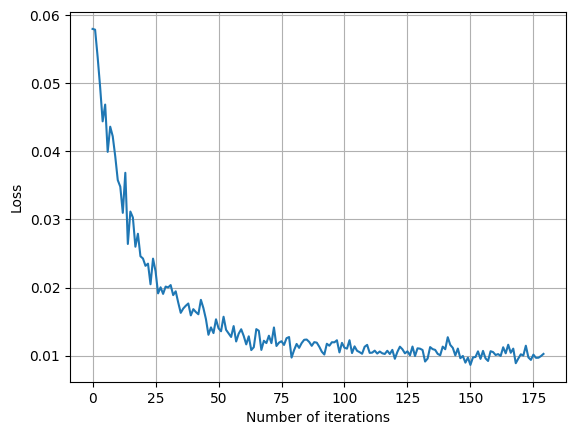

In [19]:
# Loss 그래프 plot
import matplotlib.pyplot as plt

epochs, losses = zip(*loss_values)
plt.plot(epochs, losses)
plt.xlabel('Number of iterations')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

학습이 진행됨에 따른 손실 값 변화를 보고 손실이 크게 줄어드는 것 같지 않다면 앞서 설정한 batch 등의 변수를 조정하면서 더 나은 변수를 찾아보길 바란다.
이제 오토인코더가 학습을 마쳤으니 워드 임베딩을 만들 수 있게 되었다. 데이터셋을 오토인코더에 안에 있는 인코더만 통과하도록 한 후 그 결과를 출력해보면 우리가 얻고자 했던 데이터의 워드 임베딩 된 형식을 얻을 수 있다. 이 결과를 먼저 ‘my_vectors’란 이름으로 저장해보자.

In [20]:
with torch.no_grad():
    # 여기에 코드 작성
    my_vectors = model.encoder(x_wiki)

In [21]:
my_vectors

tensor([[-0.5924,  1.0208, -0.3528,  ...,  3.1741, -0.7529,  1.5414],
        [-0.8776,  0.7919,  0.0754,  ...,  2.8433, -0.5023,  1.6440],
        [-0.7017,  1.2627,  0.1123,  ...,  2.8867, -0.5984,  1.4555],
        ...,
        [-0.2898, -0.1366, -0.0058,  ...,  0.1039,  0.1562,  0.0861],
        [-0.3885, -0.2339, -0.0203,  ...,  0.1047, -0.0869,  0.2606],
        [-0.1687, -0.2766,  0.1718,  ..., -0.0534,  0.0536,  0.1040]])

  
### 4. 학습을 완료한 오토인코더 모델 평가

이렇게 워드 임베딩을 얻었으니 잘 코드를 작성했는지 확인해보기 위해 단어 “king”에 해당하는 벡터가 갖는 처음 10개 요소로는 어떤 코드가 있을지 확인해보자.

In [22]:
# 여기에 코드 작성
my_vectors[word2code["king"]][0:10]

tensor([-0.4671,  0.9197,  1.0113, -0.1887, -0.5991, -0.5522, -0.5063,  0.4166,
        -0.7169, -1.1536])

이렇게 성공적으로 얻은 워드 임베딩이 어떤 형태를 띠고 있는지 알아볼 것이다. 그 전에 gensim이 갖는 기능을 활용할 수 있도록 하기 위해서 아래 코드로 gensim에 단어 벡터들을 저장하고 다시 불러올 것이다.

In [23]:
print(max_vocab_words)

10000


In [24]:
d = 200 # 워드 임베딩이 갖는 차원을 의미한다.

# word2vec 형식으로 저장해야 한다.(첫 줄은 단어 수와 차원이 명시되어 있고 다른 줄은 단어 뒤에 임베딩이 붙어 나오도록 쓰여 있다.)
'''
gensim의 load_word2vec_format() 기능을 활용하기 위해 tensor에서 numpy 배열로 변환해줘야한다.
my_vectors를 .numpy()로 numpy 배열로 변환해준다.
'''
with codecs.open(f"my_vectors_{d}.txt", "w", "utf-8") as f:
    f.write(str(max_vocab_words) + " " + str(d) + "\n")

    for i in range(max_vocab_words):
      f.write(sorted_words[i] + " " + " ".join([str(x) for x in my_vectors.numpy()[i, :]]) + "\n")

In [25]:
# 다시 불러오기
embeddings = KeyedVectors.load_word2vec_format("my_vectors_200.txt", binary = False)

앞서 임베딩 실습 파트에서 한 것과 유사하게 이번 실습에서 사용한 임베딩이 어떤 관계를 가지고 있는지 알아보기 위해 ‘similar_by_word’와 ‘similar_by_vector’을 이용해볼 것이다. 어떤 단어와 유사한 단어는 어떤 것이 있는지 알아보기 위해선 ‘similar_by_word’을 사용하면 되고, ‘"Athens" is to "Greece" as "Baghdad" is to ?’와 같이 물음표에 들어올 단어를 유추해야 할 때에는 ‘similar_by_vector’을 사용하면 된다. 이를 고려해 아래 코드를 채워보자.

In [26]:
# 여기에 코드 작성
embeddings.similar_by_word("red")

[('blue', 0.8816277384757996),
 ('green', 0.8365048170089722),
 ('white', 0.8324111700057983),
 ('yellow', 0.8176669478416443),
 ('cross', 0.7733170390129089),
 ('black', 0.7624877095222473),
 ('sea', 0.7529332041740417),
 ('gold', 0.7225258946418762),
 ('river', 0.7222834825515747),
 ('mountain', 0.7220611572265625)]

이제 우리가 가진 임베딩을 테스트해보자. 여기서 테스트한다는 의미는 워드 임베딩이 오토인코더의 인코더를 통과하며 잘 생성되었는지 확인한다는 것이다. 워드 임베딩은 우리가 지정한 어떤 축소된 차원에 단어가 벡터 형태로 매핑되는 것인데, 이 과정에서 유사성을 띠는 단어는 서로 비슷한 위치 관계를 갖고 있는 것을 알고 있다. 또한, 유사성 외에도 단어가 갖는 단어 벡터로 어떤 단어가 문장에 등장할지 유추하는 것이 가능했다. 따라서 워드 임베딩을 테스트하기 위해 워드 임베딩이 단어가 가진 유사성과 유추 문제 해결을 얼마나 잘 수행하는지 확인해야 한다.

이는 gensim 라이브러리가 가진 KeyedVectors.accuracy라는 방법을 이용하면 된다. 이때 사용할 데이터 파일은 word2vec을 연구하는 사람들이 만들어낸 유추 집합으로 예를 들어 ‘"Athens" is to "Greece" as "Baghdad" is to ?’의 문장은 ‘Athens Greece Baghdad Iraq’와 같이 네 단어로 이루어진 튜플 형태로 파일 내에 존재한다. 이제 파일 내에 10,000개 이상의 유추 집합을 마주했을 때 얼마나 유추를 잘 해내는지를 통해 정확도를 측정할 것이다. 아래 코드를 이용해서 데이터를 불러온 후 정확도를 얻어보자. 파일은 ‘questions-words.txt’를 다운 받으면 된다.

In [27]:
# ’https://gist.github.com/iamaziz/8d8d8c08c7eeda707b9e‘에서의 결과 압축을 풀기 위한 코드:
def unpack_accuracy(results):
    sum_corr = len (results[-1][-1]['correct'])
    sum_incorr = len (results[-1][-1]['incorrect'])
    total = sum_corr + sum_incorr
    percent = lambda a: round(a/total*100, 2)
    print(f'Total sentences: {total}, Correct: {percent(sum_corr)}%, Incorrect: {percent(sum_incorr)}%')

In [29]:
# 아래의 코드는 시간이 다소 걸릴 수 있다.
results = embeddings.evaluate_word_analogies("/content/drive/MyDrive/OUTTA/week8/questions-words.txt")
unpack_accuracy(results)

# 약 30%의 정확도를 얻을 수 있을 것이다.

Total sentences: 6275, Correct: 26.68%, Incorrect: 73.32%


### 배운 내용 되돌아보기

□ 워드 임베딩 개념 파트에서 잠시 언급했던 문맥 행렬을 통해 워드 임베딩 하는 방법을 배우고 이를 오토인코더가 학습할 수 있도록 하는 실습을 진행하였다.

□ 단어가 등장한 횟수에 따라 주어진 문장을 재배치한 후 코드를 부여하는 함수를 짜서 문맥 행렬 형성을 위한 기반을 다졌다.

□ 문맥 행렬을 형성할 수 있는 함수를 작성하였고, 아직 임베딩 되지 않은 데이터셋으로부터 문맥 행렬을 생성하여 오토인코더가 학습하기 위한 준비를 마쳤다.

□ 이때, 문맥 행렬의 크기를 무한정 늘릴 수 없어, max_vocab_words(중심어가 가질 수 있는 코드의 최댓값)와 max_context_words(문맥어가 가질 수 있는 코드의 최댓값)를 임의로 설정하여 문맥 행렬에 반영할 단어에 제한을 두었다는 점이 중요했다.

□ 문맥 행렬을 학습한 오토인코더를 평가하기 위해 오토인코더의 인코더만을 통과한 데이터가 유사한 단어를 잘 찾는지, 또 유추 문제를 잘 해결하는지 확인하였다. 30% 정도의 낮은 정확도를 보인 이유는 문맥 행렬에 모든 단어가 반영되지 못한 점, 그리고 데이터셋의 용량이 작았던 점을 들 수 있다.
  

참고문헌
1. Ryan Soklaski, <Word Embeddings and Autoencoders>, 《CogWorks》, 〈https://rsokl.github.io/CogWeb/Language/WordEmbeddings.html〉, 2021.01.03. 방문
2. Huimin Li, et al., <A Comparison of Weight Initializers in Deep Learning-based Side-channel Analysis>, 《Applied Cryptography and Network Security Workshops》, pp. 126-143 (2020)